<a href="https://colab.research.google.com/github/shiyuhu1933/Neural-Style-Transfer/blob/main/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Style Transfer

<h4>Designed by Xide Xia, with help from Ashok Cutkosky and Brian Kulis.Shiyu Hu implemented. <br> </h4>


--- 

This code has been tested on Colab. 



---

### Local installation
The alternative is to have a local installation, although we do not recommend it. If you are working on Google Colab, feel free to skip to the next section "More instructions". We recommend using virtual environments for all your installations. Following is one way to set up a working environment on your local machine for this assignment, using [Anaconda](https://www.anaconda.com/distribution/): 

- Download and install Anaconda following the instructions [here](https://docs.anaconda.com/anaconda/install/)
- Create a conda environment using `conda create --name dl_env python=3` (You can change the name of the environment instead of calling it `dl_env`)
- Now activate the environment using : `conda activate dl_env`
- Install jupyter lab, which is the [jupyter project's](https://jupyter.org/index.html) latest notebook interface : `pip install jupyterlab`. You can also use the classic jupyter notebooks and there isn't any difference except the interface.
- Install other necessary libraries. For this assignment you need `numpy`, `scipy` , [`pytorch`](https://pytorch.org/get-started/locally/) and `matplotlib`, all of which can be installed using : `pip install <lib_name>`. Doing this in the environment, would install these libraries for `dl_env`. You can also use `conda install`.
- Now download the assignment notebook in a local directory and launching `jupyter lab` in the same directory should open a jupyter lab session in your default browser, where you can open and edit the ipython notebook.
- For deactivating the environment when you are done with it, use : `conda deactivate`.

For users running a Jupyter server on a remote machine :
- Launch Jupyter lab on the remote server (in the directory with the homework ipynb file) using : `jupyter lab --no-browser --ip=0.0.0.0`
- To access the jupyter lab interface on your local browser, you need to set up ssh port forwarding. This can be done by running : `ssh -N -f -L localhost:8888:localhost:8888 <remoteuser>@<remotehost>`. You can now open `localhost:8888` on your local browser to access jupyter lab. This assumes you are running jupyter lab on its default port 8888 on the server.
- Check "Making life easy" section at the end of [this post](https://ljvmiranda921.github.io/notebook/2018/01/31/running-a-jupyter-notebook/) to find how to add functions to your bash run config to do this more easily each time. The post mentions functions for jupyter notebook, but just replace those with jupyter lab if you are using that interface.

The above instructions specify one way of working on the assignment. You can use other virtual environments/ipython notebook interfaces etc. (**not recommended**).

---

### More instructions

If you are new to Python or its scientific library, Numpy, there are some nice tutorials [here](https://www.learnpython.org/) and [here](http://www.scipy-lectures.org/).

In an ipython notebook, to run code in a cell or to render [Markdown](https://en.wikipedia.org/wiki/Markdown)+[LaTeX](https://en.wikipedia.org/wiki/LaTeX) press `Ctrl+Enter` or `[>|]`(like "play") button above. To edit any code or text cell (double) click on its content. To change cell type, choose "Markdown" or "Code" in the drop-down menu above.





In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms


---

#  Neural style transfer

In this problem, we will use deep learning to compose one image in the style of another image. This is known as [neural style transfer](https://towardsdatascience.com/a-brief-introduction-to-neural-style-transfer-d05d0403901d) and the technique is outlined in paper [A Neural Algorithm of Artistic Style (Gatys et al.)](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf). Paper is attached.

Neural style transfer is an optimization technique used to take two images—a content image and a style reference image (such as an artwork by a famous painter)—and blend them together so the output image looks like the content image, but “painted” in the style of the style reference image.

This is implemented by optimizing the output image to match the content statistics of the content image and the style statistics of the style reference image. These statistics are extracted from the images using a convolutional network.

![inputs](https://www.tensorflow.org/tutorials/generative/style_transfer_files/output__UWQmeEaiKkP_0.png)
![output](https://www.tensorflow.org/tutorials/generative/style_transfer_files/output_iYSLexgRKSh-_0.png)

In [ ]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

## 4.0 Visualize the inputs

We provide two images, starry.jpg and golden.jpg, for style and content input respectively. To save runtime, we downscale the images to (128,128). You are welcome to play with your own inputs at any resolution scale (note a larger resolution requires more runtime). To upload files to your colab notebook, you can click on  `files` on the left side of your notebook then choose upload.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# desired size of the output image
imsize = (128,128)

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("starry.jpg")
content_img = image_loader("golden.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

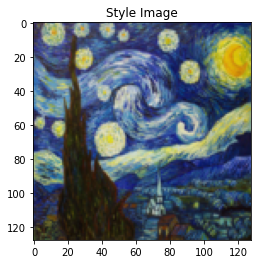

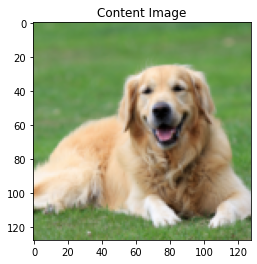

In [ ]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

## 4.1 Loss functions

The cost function has two terms - a content loss term and a style loss term, both of which are explained below.

### 4.1.1 Content Loss

The content of an image is represented by the values of the intermediate feature maps.  This is based on the intuition that images with similar content will have similar representation in the higher layers of the network. Let $p$ and $x$ be the original image and the image that is generated,

<img src="content_loss.png" width="300">

where $P^l$ is the representation of the original image and $F^l$ is the representation of the generated image in the feature maps of layer $l$.

Finish the ContentLoss() to match the corresponding content target representations. (hint: You can implement the ContentLoss using pytorch buildin mse_loss())

In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):       
        self.loss = F.mse_loss(input, self.target) ## -- ! code required  
        return input


### 4.1.2 Style Loss

The style loss is implemented similarly to the content loss. It will act as a transparent layer in a network that computes the style loss of that layer. In order to calculate the style loss, we need to compute the gram matrix. A gram matrix is the result of multiplying a given matrix by its transposed matrix. 

<img src="gram.png" width="200">


Let $~a$ and $~x$ be the original image and the image that is generated, 

<img src="style_loss.png" width="300">

Here, $A^l$ is the representation of the original image and $G^l$ is the representation of the generated image in layer $l$. $N_l$ is the number of feature maps and $M_l$ is the size of the flattened feature map in layer $l$. $w_l$ is the weight given to the style loss of layer $l$.

Complete the gram_matrix() to alculate a Gram matrix that includes this information and finish the StyleLoss().

In [ ]:
from inspect import getinnerframes
def gram_matrix(input):
    gram = 0
    ## -- ! code required
    ##batch size x, feature b, dimension z,w
    x, y, z, w = input.size()  
    f_hat = input.view(x * y, z * w)  
    gram = torch.mm(f_hat, f_hat.t())  
    gram = gram.div(x * y * z * w)
    return gram
class StyleLoss(nn.Module):

    def __init__(self, target):
        super(StyleLoss, self).__init__()
        self.target = self.target = target.detach()
        self.target = gram_matrix(target)
    def forward(self, input):
      ## -- ! code required 
        self.loss = F.mse_loss(gram_matrix(input), self.target)
        return input

### 4.1.3 Import a pre-trained VGG-19.

Now we need to import a pre-trained neural network. We will use a 19 layer VGG network like the one used in the paper.

Import a pretrained VGG-19 from [torchvision.models](https://pytorch.org/docs/stable/torchvision/models.html). Make sure to set the network to evaluation mode using .eval().

In [ ]:
## -- ! code required  

import torchvision.models as models
cnn = models.vgg19(pretrained=True).features.to(device).eval()

### 4.1.4 VGG-19 pre-processing

VGG networks are trained on images with each channel normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]. 

Complete Normalization() to normalize the image before sending it into the network.

In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()    
        self.mean = mean.clone().detach()
        self.std = std.clone().detach()


    def forward(self, img):
        # normalize img
        ## -- ! code required  
        normalized_img = (img - self.mean.view(-1, 1, 1)) / self.std.view(-1, 1, 1) 
        return normalized_img 

### 4.1.5 Get content/style representations

Choose intermediate layers from the network to represent the style and content of the image. Use the selected intermediate layers of the model to get the content and style representations of the image. In this problem, you are using the VGG19 network architecture, a pretrained image classification network. These intermediate layers are necessary to define the representation of content and style from the images. 

Complete the get_style_model_and_losses() so you can easily extract the intermediate layer values.

In [ ]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img, content_layers, style_layers):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
            
        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            ## -- ! code required  
            #input_c = model(content_img).detach()
            #Loss_c = ContentLoss(input_c)
            #model.add_module("Loss_c_{}".format(i), Loss_c)
            #content_losses.append(Loss_c)
            input_ct = model(content_img).detach()
            Loss_ct = ContentLoss(input_ct)
            model.add_module("Loss_ct_{}".format(i), Loss_ct)
            content_losses.append(Loss_ct)
            
            
        if name in style_layers:
            # add style loss:
            ## -- ! code required  
            #input_s = model(style_img).detach()
            #Loss_s = StyleLoss(input_s)
            #model.add_module("Loss_s_{}".format(i), Loss_s)
            #style_losses.append(Loss_s)  
            input_st = model(style_img).detach()
            Loss_st = StyleLoss(input_st)
            model.add_module("Loss_st_{}".format(i), Loss_st)
            style_losses.append(Loss_st)
            

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:(i + 1)]
    return model, style_losses, content_losses



## 4.2 Build the model

### 4.2.1 Perform the neural transfer
 
Finally, we must define a function that performs the neural transfer. To transfer the style of an artwork $~a$ onto a photograph $~p$ we synthesise a new image that simultaneously matches the content representation of $~p$ and the style representation of $~a$. Thus we jointly minimise the distance of the feature representations of an initial image from the content representation of the photograph in one layer and the style representation of the painting defined on a number of layers of the Convolutional Neural Network. The loss function we minimise 

<img src="total_loss.png" width="400">

where α and β are the weighting factors for content and
style reconstruction, respectively.

For each iteration of the networks, it is fed an updated input and computes new losses. We will run the backward methods of each loss module to dynamicaly compute their gradients. The paper recommends LBFGS, but Adam works okay, too.

Compelte the run_style_transfer().

In [ ]:
content_layers_selected = ['conv_4']
style_layers_selected = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1,
                       content_layers=content_layers_selected,
                       style_layers=style_layers_selected):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img, content_layers, style_layers)

    optimizer = optim.Adam([input_img.requires_grad_()], lr=0.1, eps=1e-1)

    
    print('Optimizing..')
    step_i = 0
    while step_i <= num_steps:
        
            
            input_img.data.clamp_(0, 1)
            ## -- ! code required

            
            model(input_img)
            optimizer.zero_grad()
            model(input_img)
            style_score, content_score = 0, 0
            for loss_s in style_losses:
                style_score += loss_s.loss
            for loss_c in content_losses:
                content_score += loss_c.loss
            style_score = style_weight * style_score
            content_score = content_weight * content_score
            Total_loss = content_score + style_score
            Total_loss.backward()
            optimizer.step()
            step_i += 1
            if step_i % 50 == 0:
                print("run {}:".format(step_i))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

           

  

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

### 4.2.2 Test your model

Now you have done your coding tasks, let's test them!

Building the style transfer model..
Optimizing..
run 50:
Style Loss : 787.755737 Content Loss: 41.486801

run 100:
Style Loss : 154.602707 Content Loss: 40.870289



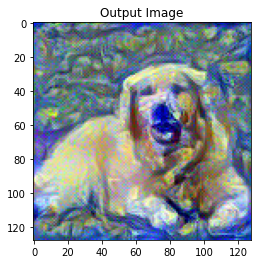

In [ ]:
content_layers_selected = ['conv_4']
style_layers_selected = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
style_weight=1000000
input_img = content_img.clone().detach().requires_grad_(True)

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=100,style_weight=style_weight,
                            content_layers=content_layers_selected,
                            style_layers=style_layers_selected)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

## 4.3 Content/style loss weight ratio

Try two different style loss weights: 5000 and  10. Discuss what you learn from the results.

Building the style transfer model..
Optimizing..
run 50:
Style Loss : 5.544325 Content Loss: 13.153692

run 100:
Style Loss : 3.512279 Content Loss: 11.652704



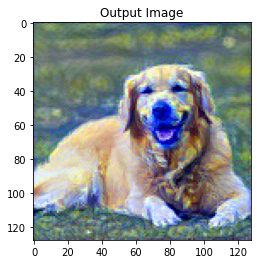

In [ ]:
content_layers_selected = ['conv_4']
style_layers_selected = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
style_weight=5000
input_img = content_img.clone().detach().requires_grad_(True)

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=100,style_weight=style_weight,
                            content_layers=content_layers_selected,
                            style_layers=style_layers_selected)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

Building the style transfer model..
Optimizing..
run 50:
Style Loss : 0.283692 Content Loss: 0.003655

run 100:
Style Loss : 0.283272 Content Loss: 0.003861



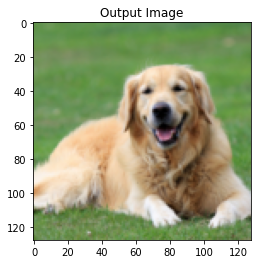

In [ ]:
content_layers_selected = ['conv_4']
style_layers_selected = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
style_weight=10
input_img = content_img.clone().detach().requires_grad_(True)

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=100,style_weight=style_weight,
                            content_layers=content_layers_selected,
                            style_layers=style_layers_selected)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

***your solution:***

hyperparameters style_weight determines whether the output is more style oriented or content oriented.

## 4.4 Choose different intermediate layers

Try three different intermediate layers for style representations: conv_1, conv_3 and conv_5. Discuss what you learn from the results.

Building the style transfer model..
Optimizing..
run 50:
Style Loss : 2.284571 Content Loss: 3.393035

run 100:
Style Loss : 0.943908 Content Loss: 2.797651



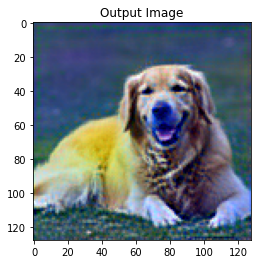

In [ ]:
content_layers_selected = ['conv_4']
style_layers_selected = ['conv_1']
style_weight=1000000
input_img = content_img.clone().detach().requires_grad_(True)

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=100,style_weight=style_weight,
                            content_layers=content_layers_selected,
                            style_layers=style_layers_selected)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

Building the style transfer model..
Optimizing..
run 50:
Style Loss : 107.184837 Content Loss: 29.926174

run 100:
Style Loss : 25.684345 Content Loss: 29.186634



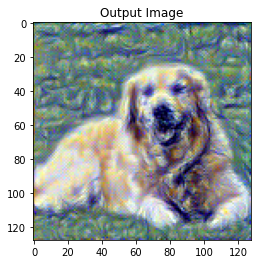

In [ ]:
content_layers_selected = ['conv_4']
style_layers_selected = ['conv_3']
style_weight=1000000
input_img = content_img.clone().detach().requires_grad_(True)

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=100,style_weight=style_weight,
                            content_layers=content_layers_selected,
                            style_layers=style_layers_selected)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

Building the style transfer model..
Optimizing..
run 50:
Style Loss : 493.816986 Content Loss: 46.057400

run 100:
Style Loss : 101.919647 Content Loss: 42.722500



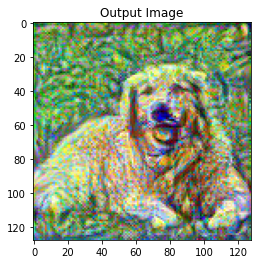

In [ ]:
content_layers_selected = ['conv_4']
style_layers_selected = ['conv_5']
style_weight=1000000
input_img = content_img.clone().detach().requires_grad_(True)

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=100,style_weight=style_weight,
                            content_layers=content_layers_selected,
                            style_layers=style_layers_selected)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()